# Encoded Processed Data


This Notebook take the processed data instance & encodes the data to prepare for anaylsis, some additional clean may also be performed.

The idea is for these functions to be used when training the models.


#### Function
Abstracted class to process raw data.

#### Input
- file path: processed data instance 
- file path: write path

#### Output
- stored class hosting the processed data.

> Note: The **Encoding** class inherits all methods & properties from it's parent class: _batch_processing_.

---------
```
Zach Wolpe
zachcolinwolpe@gmail.com
29 June 2021
```
---------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import sys
from tqdm import tqdm
import pickle
import plotly.express as px
import plotly.graph_objects as go

# ---- load data module ----x

import sys
sys.path.append('')
from process_data_raw_class import batch_processing 

In [3]:
# ---- fetch data object ----x
with open('../data objects/batch_processing_object.pkl', 'rb') as file2:
    bp = pickle.load(file2)
bp.__dict__.keys()

dict_keys(['path', 'metadata', 'mapping', 'data_times', 'participants', 'parti_code', 'n', 'wcst_paths', 'nback_paths', 'corsi_paths', 'fitts_paths', 'navon_paths', 'wcst_data', 'nback_data', 'corsi_data', 'fitts_data', 'navon_data', 'individual_data', 'MTurk'])

In [4]:
bp.describe_data()



        ------------------------------------------------------------------
            self.path            : raw data loc
            self.metadata        : mturk metadata
            self.mapping         : reference table
            self.data_times      : reference times table
            self.participants    : list of participant identifiers
            self.parti_code      : list of participant codes
            self.n               : total number of samples
            self.wcst_paths      : paths to wcst  raw data
            self.nback_paths     : paths to nback raw data
            self.corsi_paths     : paths to corsi raw data
            self.fitts_paths     : paths to fitts raw data
            self.navon_paths     : paths to navon raw data
            self.wcst_data       : wcst  dataframe
            self.nback_data      : nback dataframe
            self.corsi_data      : corsi dataframe
            self.fitts_data      : fitts dataframe
            self.navon_data    

In [5]:
class encode_data:
    def __init__(self, bp):
        self.raw = bp

        # ---- fitts ----x
        bp.fitts_data['delta']  = bp.fitts_data['fitts_prediction'] - bp.fitts_data['reaction_time_ms']
        self.fitts              = bp.fitts_data.groupby(['participant']
                                    ).agg({'delta': ['mean', 'std'], 'status': ['mean', 'std']}).reset_index()

        # ---- corsi ----x
        self.corsi = bp.corsi_data.groupby(['participant']).agg(
            {'highest_span': ['max'], 'n_items': ['max'], 'status': ['mean', 'std']}).reset_index()

        # ---- navon ----x
        x = bp.navon_data
        x['correct']  = x['status'] == 1
        x['too_slow'] = x['status'] == 3
        x = x.groupby(['participant', 'level_of_target']).agg(
            {'correct': ['mean', 'std'],
            'too_slow': ['mean', 'std'],
            'reaction_time_ms': ['mean', 'std']
            })
        x = x.reset_index()
        self.navon = x


    def plot_random_fitts(self, all=False, color='lightblue'):
        x = self.raw.fitts_data
        p = np.random.choice(x.participant.unique())
        if not all:
            x.loc[x['participant'] == p,].hist('delta', bins=20, color=color)
            plt.title(f'Participant: {round(p)}')
            plt.axvline(x.loc[x['participant'] == p, ['delta']].mean()[0], color='#e390ba', linewidth=2, linestyle='--')
            plt.xlabel('Fitts Delta')
        else:       
            x.loc[:, ['delta']].hist(bins=20, color=color)
            plt.axvline(x.loc[:, ['delta']].mean()[0], color='maroon', linestyle='--')
            plt.title('All Participants')
        plt.xlabel('Fitts Delta')


    def plot_corsi(self, color='#00a0b0'):
        x = self.corsi
        x.highest_span.hist(label='Corsi Span', color=color)
        xbar = x['highest_span'].mean()[0]
        plt.axvline(xbar, color='#ff8cb9', linestyle='--', linewidth=2, label=f'mean: {xbar}')
        plt.legend()
        plt.title('Corsi Block Span')
        plt.ylabel('frequency')
        plt.xlabel('Corsi Block Span')
        plt.show()


    def plot_navon(self, color='#6f235f'):
        self.navon.hist(color=color)
        plt.tight_layout()
        plt.show()



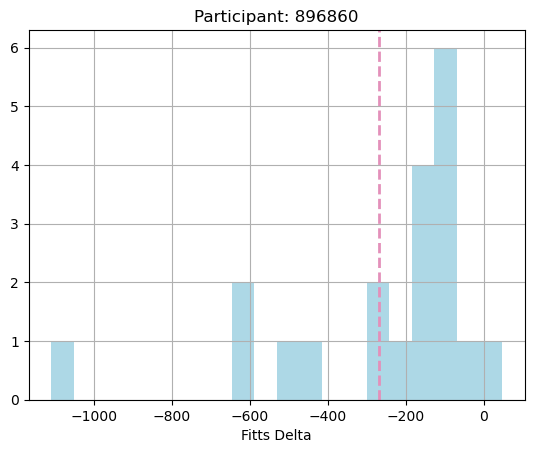

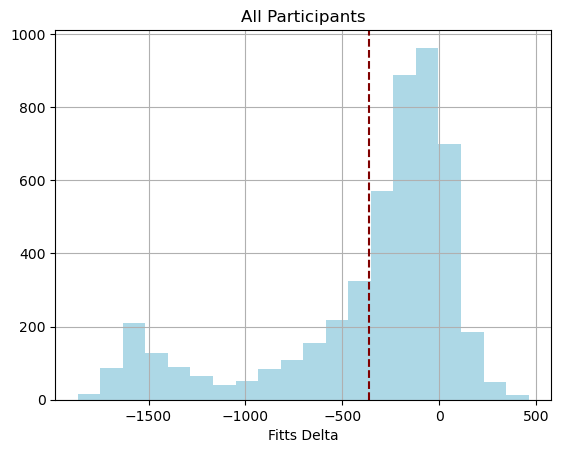

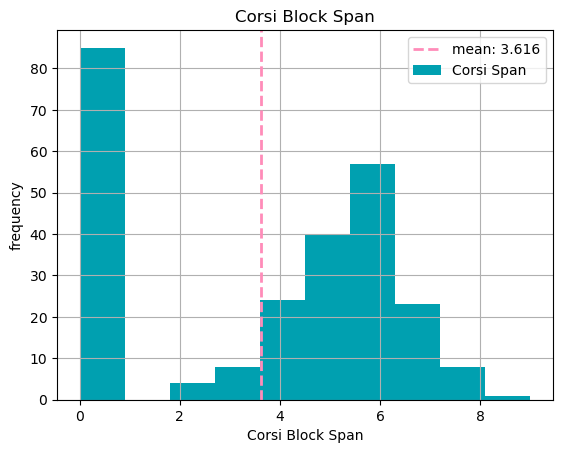

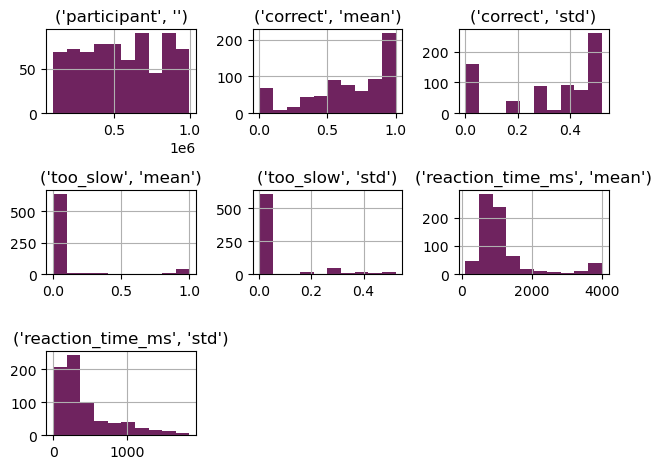

In [6]:
ed = encode_data(bp)
plt.style.use('default')
ed.plot_random_fitts(all=False)
ed.plot_random_fitts(all=True)
ed.plot_corsi()
ed.plot_navon()

# Summary States

In [76]:
# # ---- navon ----x
p = np.random.choice(ed.navon.participant, 1)[0]
p
ed.navon.loc[ed.navon['participant']==p,]


participant level_of_target   correct            too_slow            \
                                     mean       std      mean       std   
0      100934.0          global  0.166667  0.389249  0.000000  0.000000   
3      103322.0          global  0.923077  0.277350  0.000000  0.000000   
6      107700.0          global  0.916667  0.288675  0.000000  0.000000   
9      117200.0          global  0.333333  0.492366  0.083333  0.288675   
12     117306.0          global  0.692308  0.480384  0.000000  0.000000   
..          ...             ...       ...       ...       ...       ...   
708    978676.0          global  0.000000  0.000000  0.166667  0.389249   
711    979785.0          global  0.916667  0.288675  0.000000  0.000000   
714    984020.0          global  1.000000  0.000000  0.000000  0.000000   
717    987993.0          global  0.583333  0.514929  0.000000  0.000000   
720    998593.0          global  0.416667  0.514929  0.083333  0.288675   

    reaction_time_ms               
                mean          std  
0         664.583333   221.989540  
3         959.769231   358.604739  
6         723.916667   196.503277  
9         859.083333  1307.195364  
12       1267.000000   446.435326  
..               ...          ...  
708      1259.166667  1398.989235  
711       723.500000   197.250418  
714       679.307692   124.298287  
717       671.166667   332.101527  
720      2194.500000   942.982551  

[241 rows x 8 columns]

In [88]:
import plotly.offline as pyo
import plotly.graph_objs as go

x = ed.navon

# colors 
types = [x for x in x.level_of_target.unique()]
cols = list(np.random.choice(range(256), size=len(types)))

data = []
for t in range(len(types)):
    xx = x.loc[x.level_of_target == types[t], ]
    data.append(
        go.Scatter(y=xx.correct['mean'], x=xx.reaction_time_ms['mean'], 
        mode='markers', marker=dict(
            size=12,  
            color=cols[t],
            symbol='circle', 
            line={'width':1, 'color':'white'}
            ))
    )
    

# layout = go.Layout(title='% Correct', xaxis={'title': 'reaction time'}, yaxis={'title': '% correct'})


# fig = go.Figure(data=data, layout=layout)
pyo.plot(data, filename='scatter.html')

'scatter.html'

In [89]:
cols[t]

193